# Lecture 23 : GPU Hello World and Sum

## We will learn to program Nvidia GPUs using CUDA (Compute Unified Device Architecture).  

## Google Colab gives free access (be responsible!) to a Nvidia T4 GPU (Turing Class).  

## Here is a picture of a Turing Class GPU (not T4).

## Such a GPU is capaple of performing thousands of calculations simultaneously!

## The TU102 shown here has 72 SMs (stream multiprocessors).  

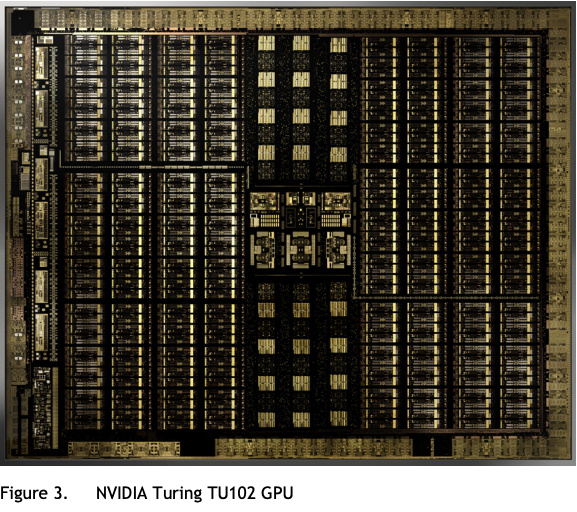

## The Nvidia T4 is a version of the TU104 GPU (shown below) that has 40 SMs.  

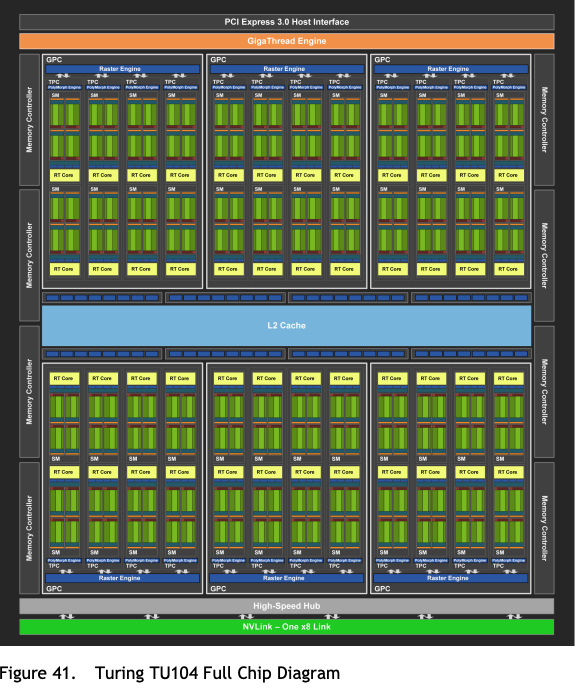

## One of the 40 SMs on the T4 is shown below.  

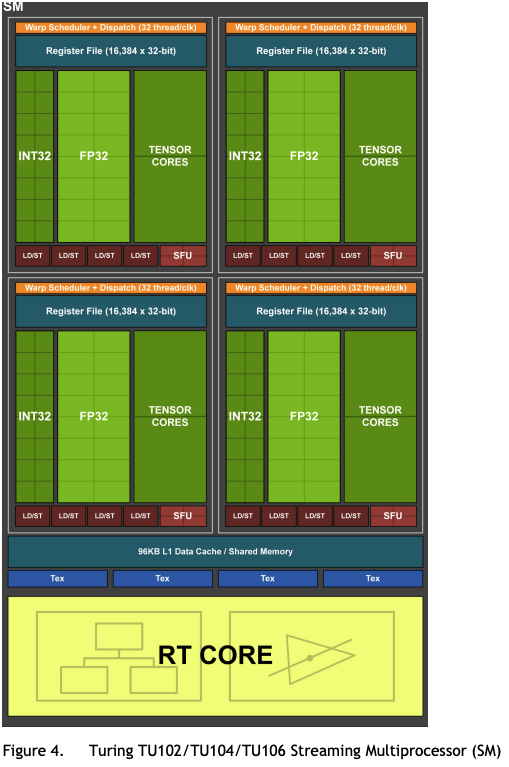

## Here is our first CUDA program : Hello World!

## Note that a CUDA source file ends with *.cu* and we must include *cuda.h*

## A CUDA kernel such as the helloKernel shown below is executed by each thread.  

## A CUDA kernel is a similar to a OpenMP parallel region but there are some differences.

## We use the command given in line 26 to launch the kernel.

## The parameters between the <<< and >>> are called *launch parameters*.

## The first launch parameter is the number of thread blocks.    

## The second launch parameter is the number of threads per thread block.  

## Note that for the examples in this lecture we are specifying only a single thread block.  That means that all of our threads will run on a single SM.  This is a big limitation as it means we will only use 1/40 of the full computational power of the T4 GPU.  

## Later we will learn how to use multiple thread blocks to unleash the full power of the GPU.

In [ ]:
%%writefile gpu_hello.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

__global__ void helloKernel() {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get num_threads from the command line */
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"num_threads");
        return 1;
    }

    int num_threads = atoi(argv[1]);

    printf ("num_threads = %d\n",num_threads);

    helloKernel <<< 1, num_threads >>> ();
    cudaDeviceSynchronize();
}

## To compile a CUDA source file we use *nvcc* instead of our normal *gcc*.

In [ ]:
!nvcc -arch=sm_75 -o gpu_hello gpu_hello.cu

## Run the program with 32 threads and with 128 threads.  What do you observe?

## Threads are grouped into warps of size 32.  

## Threads in a particular warp execute the same instruction simultaneously but on different data.  

## This type of parallelism is called SIMD (same instruction multiple data).

In [ ]:
!./gpu_hello 32

In [ ]:
!./gpu_hello 128

## Next let's write a CUDA program for computing the sum of the first $N$ integers.

## Recall that Gauss showed that
$$\displaystyle\sum_{i=1}^{N} i = \displaystyle\frac{N(N+1)}{2}$$

## For our first version we will just have each thread compute the entire sum and print out the result.  Note that the kernel function now has an argument.

## As in OpenMP, variables defined in a CUDA kernel (including arguments) are private variables (one for each thread) by default.  

## CUDA kernels always have a *void* return type so outputs must be returned through pointers.  

## Discussion: How would you change the kernel so that each thread only calculates only an approximately equal share of the sum?

## Note: Unlike OpenMP, both CUDA and MPI do not have built in support for scheduling for loop iterations across threads.

In [ ]:
%%writefile gpu_sum_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    uint64 sum = 0;
    for (uint64 i = 1; i <= N;i++) {
        sum += i;
    }

    printf (" on thread %d of %d, sum = %llu\n",thread_num,num_threads,sum);
}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v1 gpu_sum_v1.cu

In [ ]:
!./gpu_sum_v1 1000 2

## Here is version 2 of the kernel where each thread calculates an approximately equal share of the sum and prints the partial result.

## Discussion: In order for the threads to communicate partial results we will need to use what type of variable?

In [ ]:
%%writefile gpu_sum_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v2 gpu_sum_v2.cu

In [ ]:
!./gpu_sum_v2 1000 2

## Here is version 3 of the kernel where we use a shared variable sum.  Note as we frequently do in MPI, we designate the thread with thread_num equal to 0 as a special thread.  Note that only the thread 0 initializes the shared variable and prints the final result.  

## When we run version 3 we get the incorrect answer.  

## Discussion : Describe the problem with the kernel and a potential solution.  

In [ ]:
%%writefile gpu_sum_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v3 gpu_sum_v3.cu

In [ ]:
!./gpu_sum_v3 1000 4

## Here is version 4 of the kernel that uses an atomic add instruction to avoid the read-write race condition present in the previous version.

## Note that this version of the kernel takes a while to run on a modest N of 100 million with 32 threads.  Even though we are only using a small part of the GPU this seems very slow.  

## Discussion : Describe the problem with the kernel and a potential solution.  

## Hint: the atomic add instruction is serving the same purpose as what OpenMP construct?  What do we know about that OpenMP construct?

In [ ]:
%%writefile gpu_sum_v4.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v4 gpu_sum_v4.cu

In [ ]:
!time ./gpu_sum_v4 100000000 32

## Here is version 5 of the kernel that uses a thread version of the sum variable to pull the atomicAdd outside of the for loop.  Note in particular that each thread only executes the atomicAdd one time.  

## Note that this version of the kernel is much faster than the previous.  In fact it can now calculate a larger sum (N equal to a billion) in around one second.

## Try running the kernel with 64 threads instead of 32 threads.  What do you observe?

## Discussion : Describe the problem with the kernel and a potential solution.

## Hints : What would happen if thread 32 finishes updating the shared sum variable with its partial sum before thread 0 initializes sum to 0?  What would happen if thread 0 prints the final result before thread 32 finishes updating the shared sum variable with its partial sum?

In [ ]:
%%writefile gpu_sum_v5.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v5 gpu_sum_v5.cu

In [ ]:
!time ./gpu_sum_v5 1000000000 32

In [ ]:
!time ./gpu_sum_v5 1000000000 64

## Here is version 6 of the kernel that uses two barriers to fix the bugs in kernel 5.  
## A barrier is a line of code that all threads (in a particular thread block) must get to before any thread is allowed to continue.  
## The first barrier ensures that thread 0 initializes the sum variable to 0 before other threads are allowed to start updating the shared sum variable with the partial sums.  
## The second barrier ensures that all threads have finished adding their partial sums to the shared sum variable before thread 0 prints the final result.  

In [ ]:
%%writefile gpu_sum_v6.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    /*****************/
    /* Add Code Here */
    /*****************/

}

int main(int argc, char **argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v6 gpu_sum_v6.cu

In [ ]:
!time ./gpu_sum_v6 1000000000 64